<a href="https://colab.research.google.com/github/kairamilanifitria/RnD-ML-PB/blob/main/COLPALI_IMAGE_SEARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ColPali and Qdrant: Document Retrieval with Vision Language Models and Binary Quantization

It’s no secret that even the most modern document retrieval systems have a hard time handling visually rich documents like PDFs, containing tables, images, and complex layouts.

ColPali introduces a multimodal retrieval approach that uses Vision Language Models (VLMs) instead of the traditional OCR and text-based extraction. By processing document images directly, it creates multi-vector embeddings from both the visual and textual content, capturing the document's structure and context more effectively. This method outperforms traditional techniques, as demonstrated by the Visual Document Retrieval Benchmark (ViDoRe) introduced in the paper.

## Standard Retrieval vs. ColPali

The standard approach starts by running OCR to extract the text from a document. Once the text is extracted, a layout detection model interprets the structure, which is followed by chunking the text into smaller sections for embedding. This method works adequately for documents where the text content is the primary focus.

![Standard Retrieval architecture](https://i.ibb.co/nf0CRyL/image-278.png)

*Standard Retrieval architecture. Image from the ColPali paper [1]*

Rather than relying on OCR, ColPali processes the entire document as an image using a Vision Encoder. It creates multi-vector embeddings that capture both the textual content and the visual structure of the document which are then passed through a Language Model (LLM), which integrates the information into a representation that retains both text and visual features.

![Colpali architecture](https://i.ibb.co/S3jhwR0/image-279.png)

*Colpali architecture. Image from the ColPali paper [1]*

The retrieval quality of ColPali is significantly higher, with an NDCG@5 score of 0.81. This comes from a benchmark created by the authors to measure how well systems handle visually rich documents. ColPali's score shows that it does a better job of capturing both text and visual elements compared to traditional methods.



| Feature                  | Standard Retrieval                            | ColPali                                          |
|--------------------------|-----------------------------------------------|--------------------------------------------------|
| **Document Processing**   | OCR and text-based extraction                 | Vision-based processing using a Vision Encoder    |
| **Handling Visual Content** | Limited (depends on captioning)              | Fully integrated (handles images, tables, layouts)|
| **Embedding Creation**    | Single dense embedding from text              | Multi-vector embeddings from both text and visuals|
| **Speed (Offline)**       | 7.22 seconds per page                         | 0.39 seconds per page                            |
| **Speed (Online)**        | 22 milliseconds per query                     | 30 milliseconds per query                        |
| **Retrieval Quality**     | NDCG@5 score of 0.66                          | NDCG@5 score of 0.81                             |


## Why ColPali’s Results Are So Good

One of the standout features of ColPali is its explainability. Because it uses vision transformers, it can 'understand' which parts of a document were most relevant to a specific query. For example, if you’re searching for the page in a report that mentions a specific date, it can highlight the patches of the document where that information is found. This level of transparency is incredibly useful for understanding how the model works and verifying the accuracy of its results.

Let's take a look at this chart bellow that shows the 2019 Average Hourly Generation by Fuel Type from the [original ColPali paper](https://arxiv.org/abs/2407.01449):

<img src="https://i.ibb.co/F85HmBg/image-280.png" alt="2019 Average Hourly Generation by Fuel Type" width="600"/>

*Image from the ColPali paper [1]*

In the figure below, also presented in the ColPali paper, we can see how ColPali identifies the most relevant patches of the document in response to the query "Which hour of the day had the highest overall electricity generation in 2019?" and match the query terms like “hour” and “highest generation” to the relevant sections of the document.

<img src="https://i.ibb.co/9wwRt7r/image-277.png" alt="How ColPali identifies the most relevant document image patches" width="600"/>

*Image from the ColPali paper [1]*

The highlighted zones correspond to the areas of the document that have information relevant to the query. ColPali computes a query-to-page matching score based on these highlighted regions, allowing it to retrieve the most pertinent documents from a large pre-indexed corpus.

# Getting Started: Setting Up ColPali and Qdrant

This tutorial takes inspiration from [Daniel van Strien’s guide](https://danielvanstrien.xyz/posts/post-with-code/colpali-qdrant/2024-10-02_using_colpali_with_qdrant.html) [2] on using ColPali and Qdrant for document retrieval, working with a UFO dataset that includes tables, images, and text.

We’re experimenting with **Binary Quantization** and using oversampling and rescoring to fine-tune the results.

### Step 1: Install Required Libraries
Before diving into the code, let’s install and import the libraries we're gonna be using:

In [2]:
!pip install uv
!uv pip install --system colpali_engine>=0.3.1 datasets huggingface_hub[hf_transfer] qdrant-client transformers>=4.45.0 stamina rich

Using Python 3.11.12 environment at: /usr
Audited 7 packages in 90ms


In [3]:
import os
import torch
import time
import numpy as np
from qdrant_client import QdrantClient
from qdrant_client.http import models
from tqdm import tqdm
from datasets import load_dataset

## Step 2: Downloading the UFO Documents Dataset


We will retrieve the UFO dataset from the Hugging Face hub.

In [ ]:
#!pip install --upgrade datasets huggingface_hub

In [4]:
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1" # optional setting for faster dataset downloads

In [5]:
from datasets import load_dataset
dataset = load_dataset("davanstrien/ufo-ColPali", split="train")

In [6]:
dataset # structure of the dataset

Dataset({
    features: ['image', 'raw_queries', 'broad_topical_query', 'broad_topical_explanation', 'specific_detail_query', 'specific_detail_explanation', 'visual_element_query', 'visual_element_explanation', 'parsed_into_json'],
    num_rows: 2243
})

Let's take a look at one random document from the dataset to exemplify the complexity of the data that we'll be handling

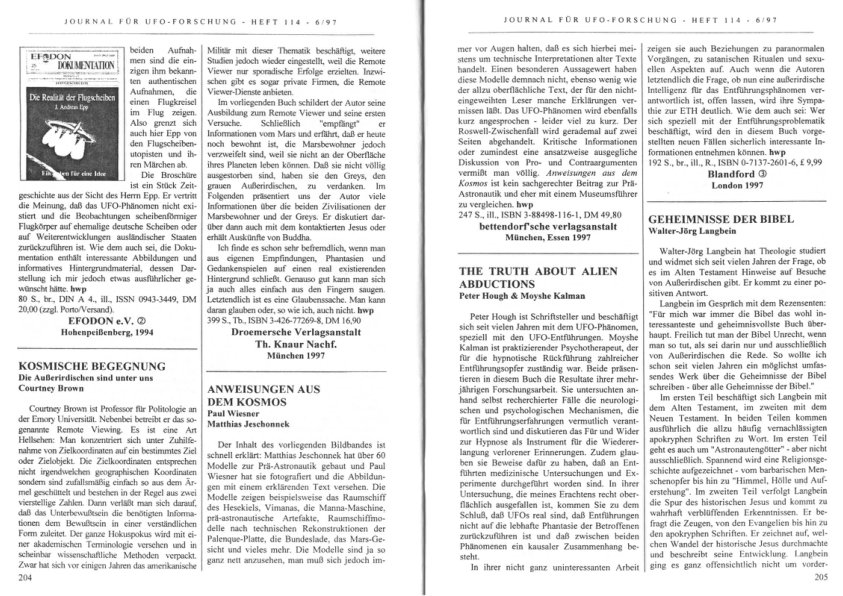

In [38]:
dataset[1001]["image"]

## Step 3: Connecting to Qdrant

For this tutorial, we'll be using a Qdrant Cloud cluster with the following specs:

DISK: 32GB
RAM: 8GB
vCPUs: 1

But don't worry! You can still follow along and perform the same searches using the [Qdrant Cloud Free Tier]((https://cloud.qdrant.io/) or in your local machine with our [Python Client](https://github.com/qdrant/qdrant-client).

In [8]:
from google.colab import userdata

In [12]:
qdrant_client = QdrantClient(
    url="__",
    api_key="__"
)

If you want to start testing without setting up persistent storage, you can initialize an in-memory Qdrant instance. **But keep in mind that the data won't persist after the session ends:**

In [ ]:
# qdrant_client = QdrantClient(
#     ":memory:"
# )

## Step 4: Setting Up ColPali

We're going to be using here a ColPali model that is fine-tuned for the UFO dataset.

In [13]:
from colpali_engine.models import ColPali, ColPaliProcessor

# Initialize ColPali model and processor
model_name = (
    "davanstrien/finetune_colpali_v1_2-ufo-4bit"  # Use the latest version available
)
colpali_model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",  # Use "cuda:0" for GPU, "cpu" for CPU, or "mps" for Apple Silicon
)
colpali_processor = ColPaliProcessor.from_pretrained(
    "vidore/colpaligemma-3b-pt-448-base"
)

adapter_config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/157M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

## Step 5: Configure your Qdrant Collection

Now let's create a collection in Qdrant. We're using binary quantization here, keeping only the quantized vectors in RAM while storing the original vectors and payloads on disk. MaxSim is being used for selecting the maximum similarity score for token-level comparisons between query and document vectors

In [14]:
collection_name = "ufo-binary"

In [15]:
qdrant_client.create_collection(
    collection_name=collection_name,
    on_disk_payload=True,  # store the payload on disk
    vectors_config=models.VectorParams(
        size=128,
        distance=models.Distance.COSINE,
        on_disk=True, # move original vectors to disk
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM
        ),
        quantization_config=models.BinaryQuantization(
        binary=models.BinaryQuantizationConfig(
            always_ram=True  # keep only quantized vectors in RAM
            ),
        ),
    ),
)

True

## Step 6: Uploading the vectors to Qdrant

In this step, we're indexing the vectors into our Qdrant Collection in batches.

For each batch, the images are processed and encoded using the ColPali model, turning them into multi-vector embeddings. These embeddings are then converted from tensors into lists of vectors, capturing key details from each image and creating a multi-vector representation for each document. This setup works well with Qdrant's multivector capabilities.

After processing, the vectors and any metadata are uploaded to Qdrant, gradually building up the index. You can lower or increase the `batch_size` depending on your avaliable GPU resources.

In [16]:
import stamina


@stamina.retry(on=Exception, attempts=3) # retry mechanism if an exception occurs during the operation
def upsert_to_qdrant(batch):
    try:
        qdrant_client.upsert(
            collection_name=collection_name,
            points=batch,
            wait=False,
        )
    except Exception as e:
        print(f"Error during upsert: {e}")
        return False
    return True

In [17]:
batch_size = 4  # Adjust based on your GPU memory constraints

# Use tqdm to create a progress bar
with tqdm(total=len(dataset), desc="Indexing Progress") as pbar:
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i : i + batch_size]

        # The images are already PIL Image objects, so we can use them directly
        images = batch["image"]

        # Process and encode images
        with torch.no_grad():
            batch_images = colpali_processor.process_images(images).to(
                colpali_model.device
            )
            image_embeddings = colpali_model(**batch_images)

        # Prepare points for Qdrant
        points = []
        for j, embedding in enumerate(image_embeddings):
            # Convert the embedding to a list of vectors
            multivector = embedding.cpu().float().numpy().tolist()
            points.append(
                models.PointStruct(
                    id=i + j,  # we just use the index as the ID
                    vector=multivector,  # This is now a list of vectors
                    payload={
                        "source": "internet archive"
                    },  # can also add other metadata/data
                )
            )

        # Upload points to Qdrant
        try:
            upsert_to_qdrant(points)
        except Exception as e:
            print(f"Error during upsert: {e}")
            continue

        # Update the progress bar
        pbar.update(batch_size)

print("Indexing complete!")

Indexing Progress: 2244it [2:00:45,  3.23s/it]

Indexing complete!


In [18]:
qdrant_client.update_collection(
    collection_name=collection_name,
    optimizer_config=models.OptimizersConfigDiff(indexing_threshold=10),
)

True

## Step 7: Processing the Query

So let's go ahead and prepare our search query. In this step, the text query "top secret" is processed and transformed into a tensor by the `colpali_processor.process_queries` function.

In [45]:
query_text = "maurizio verga"
with torch.no_grad():
    batch_query = colpali_processor.process_queries([query_text]).to(
        colpali_model.device
    )
    query_embedding = colpali_model(**batch_query)
query_embedding

tensor([[[ 0.1387, -0.0154,  0.1113,  ..., -0.0219, -0.0767, -0.0337],
         [ 0.0270, -0.0664,  0.0247,  ...,  0.0801, -0.0356,  0.0581],
         [-0.0369,  0.1367,  0.0859,  ..., -0.0137, -0.0322,  0.0223],
         ...,
         [-0.0674,  0.1738,  0.0234,  ..., -0.0718,  0.1147, -0.0082],
         [-0.0625,  0.1602,  0.0352,  ..., -0.0757,  0.1240,  0.0023],
         [-0.0518,  0.1562,  0.1108,  ..., -0.0262,  0.0127,  0.0103]]],
       device='cuda:0', dtype=torch.bfloat16)

After generating the query embedding tensor, we need to convert it into a multivector that can be used by Qdrant for searching.

In [46]:
multivector_query = query_embedding[0].cpu().float().numpy().tolist()

## Step 8: Searching and Retrieving the Documents

In this step, we perform a search to retrieve the top 10 results closer to our query multivector.

We apply rescoring to adjust and refine the initial search results by reevaluating the most relevant candidates with a more precise scoring algorithm. Oversampling is used to improve search accuracy by retrieving a larger pool of candidate results than the final number required. Finally, we measure and display how long the search process takes.

In [47]:
start_time = time.time()
search_result = qdrant_client.query_points(
    collection_name=collection_name,
    query=multivector_query,
    limit=10,
    timeout=100,
    search_params=models.SearchParams(
        quantization=models.QuantizationSearchParams(
            ignore=False,
            rescore=True,
            oversampling=2.0,
        )
    )
)
end_time = time.time()
# Search in Qdrant
search_result.points

elapsed_time = end_time - start_time
print(f"Search completed in {elapsed_time:.4f} seconds")

Search completed in 6.2695 seconds


Search completed in 0.81 seconds, nearly twice as fast as Scalar Quantization, which took 1.56 seconds according to previous tests using the same settings.

Let's now check the first match for our search query and see if we get a result similar to the original author's example, Daniel van Strien's, who used Scalar Quantization in his tutorial to see how Binary Quantization holds up in terms of accuracy and relevance.

In [48]:
idx = search_result.points[0].id
dataset[idx]["image"]

And it's a match! Both Scalar and Binary Quantization had the same top result for the same query.

However, keep in mind that this is just a quick experiment. Performance may vary, so it's important to test binary quantization on your own datasets to see how it performs for your specific use case. That said, it's promising to see binary quantization maintaining search quality while potentially offering performance improvements with ColPali.

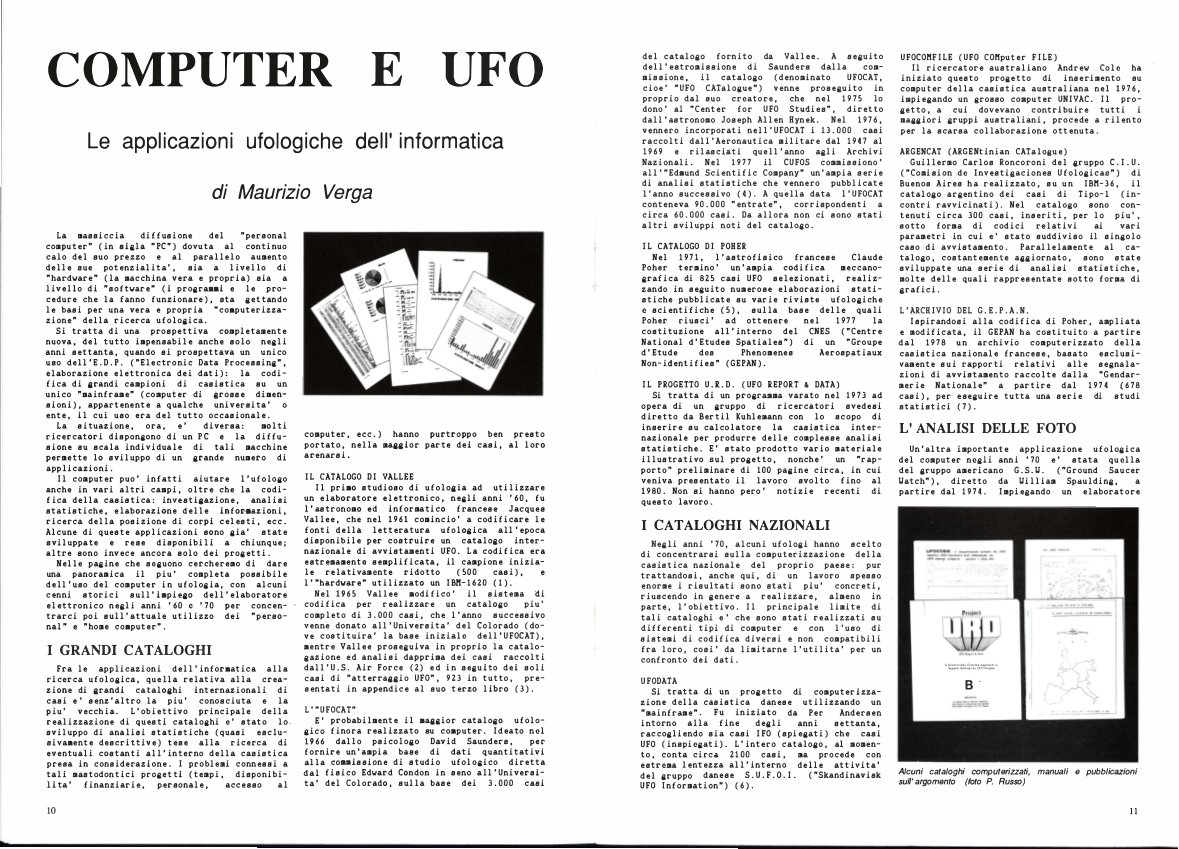

In [49]:
idx = search_result.points[1].id
dataset[idx]["image"]

In [50]:
idx = search_result.points[2].id
dataset[idx]["image"]

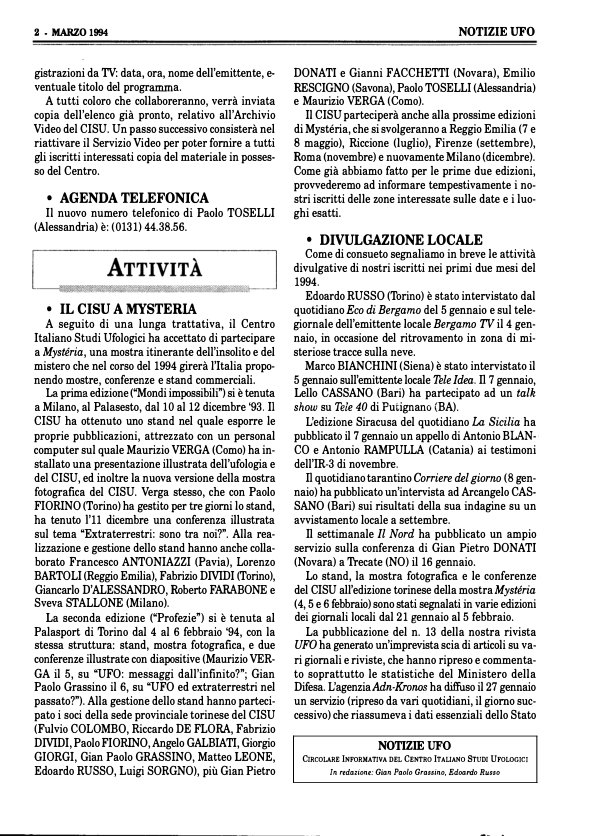

In [51]:
idx = search_result.points[3].id
dataset[idx]["image"]

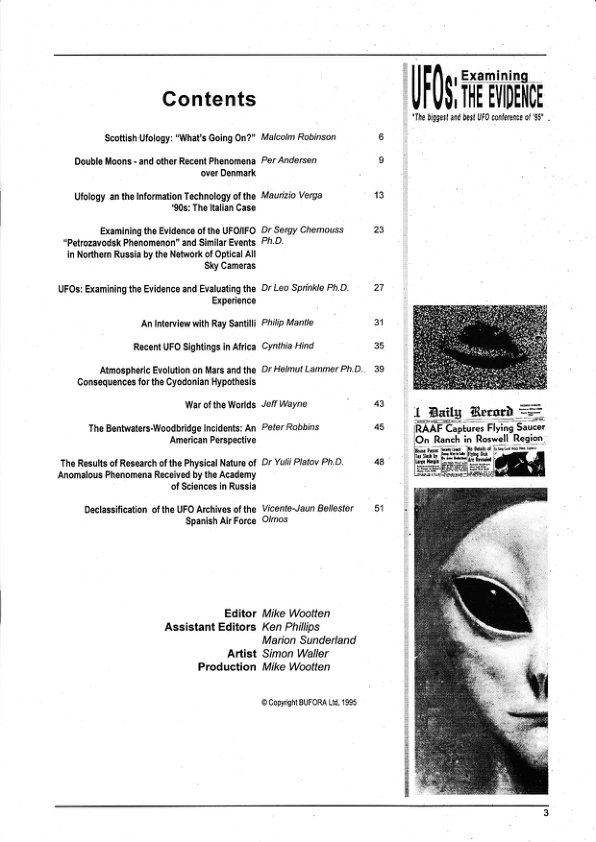

In [52]:
idx = search_result.points[4].id
dataset[idx]["image"]

In [53]:
idx = search_result.points[5].id
dataset[idx]["image"]

This is it! Feel free to experiment with your own data and settings! And remember, always evaluate both performance and quality based on your specific use case before making any final decisions.

Happy searching!

### References:
[1] Faysse, M., Sibille, H., Wu, T., Omrani, B., Viaud, G., Hudelot, C., Colombo, P. (2024). *ColPali: Efficient Document Retrieval with Vision Language Models*. arXiv. https://doi.org/10.48550/arXiv.2407.01449

[2] van Strien, D. (2024). *Using ColPali with Qdrant to index and search a UFO document dataset*. Published October 2, 2024. Blog post: https://danielvanstrien.xyz/posts/post-with-code/colpali-qdrant/2024-10-02_using_colpali_with_qdrant.html

[3] Kacper Łukawski (2024). *Any Embedding Model Can Become a Late Interaction Model... If You Give It a Chance!* Qdrant Blog, August 14, 2024. Available at: https://qdrant.tech/articles/late-interaction-models/